# Kwaterniony model AR (Levinson-Durbin)
--- 

## Wczytanie danych
---

Stabilny zapis lotu `38_bs78_out_GPS_alt2pos.ulg`.

In [1]:
import pyulog
from library.data_reader import read_attitude_quaternions, read_nav_quaternions

log = pyulog.ULog('./ulogs/38_bs78_out_GPS_alt2pos.ulg')
att_q, att_t = read_attitude_quaternions(log)
nav_q, nav_t = read_nav_quaternions(log)

## Interpolacja
---

Zaimplementowano metodę bazującą na *interpolacja funkcjami sklejanymi*, jako `spline_interpolation()`, dostarczającą bliskie wyniki. Zaimplementowano również metodę bazującą na metodzie *slerp*, jako funkcję `squad_interpolation`.  

Dla zachowania ciągłości napisano funkcję zwracającą indeksy podsekwencji rozdzielonych maksymalną odległością `discontinued_subspaces`

In [2]:
import numpy as np
from library.quaternion_interp import discontinued_subspaces, spline_interpolation

# Get pseudo continuous signal (max space 10ms)
max_space = 10e4

args_partial_signal = discontinued_subspaces(att_t, max_length = max_space)
args_part = args_partial_signal[0] # Get first part

att_t = att_t[args_part[0]:args_part[1]]
att_q = att_q[args_part[0]:args_part[1]]

# Config interpolation
dt = 4000
degree = 3

est_t = np.arange(att_t[0], att_t[-1], dt)
est_q = spline_interpolation(att_q, att_t, est_t, spline_degree=degree)

### Wynik interpolacji (składowe kwaternionu)

Do wyświetlenie rezultatów można wykorzystać `display_quaternion_compare` dla składowych kwaternionu.

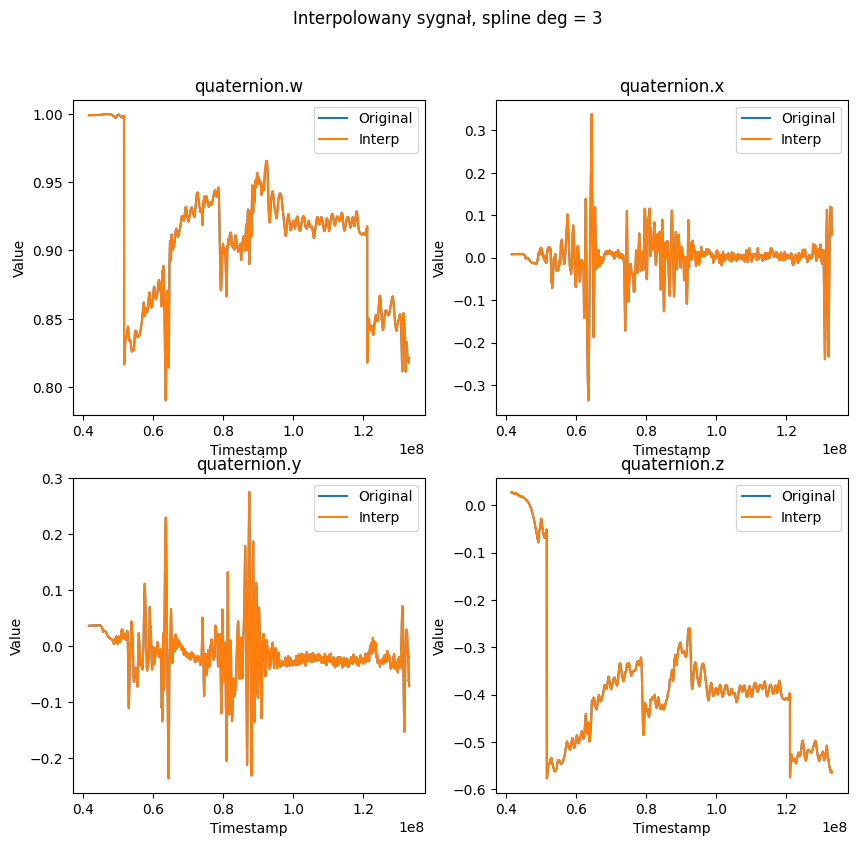

In [3]:
from library.quaternion_vision import display_quaternion_compare

display_quaternion_compare([att_q, est_q], [att_t, est_t], ['Original', 'Interp'],
    "Interpolowany sygnał, spline deg = {}".format(degree))

### Wynik interpolacji (kąty Eulera)

W przypadku kątów Eulera `display_quaternion_as_euler`. 

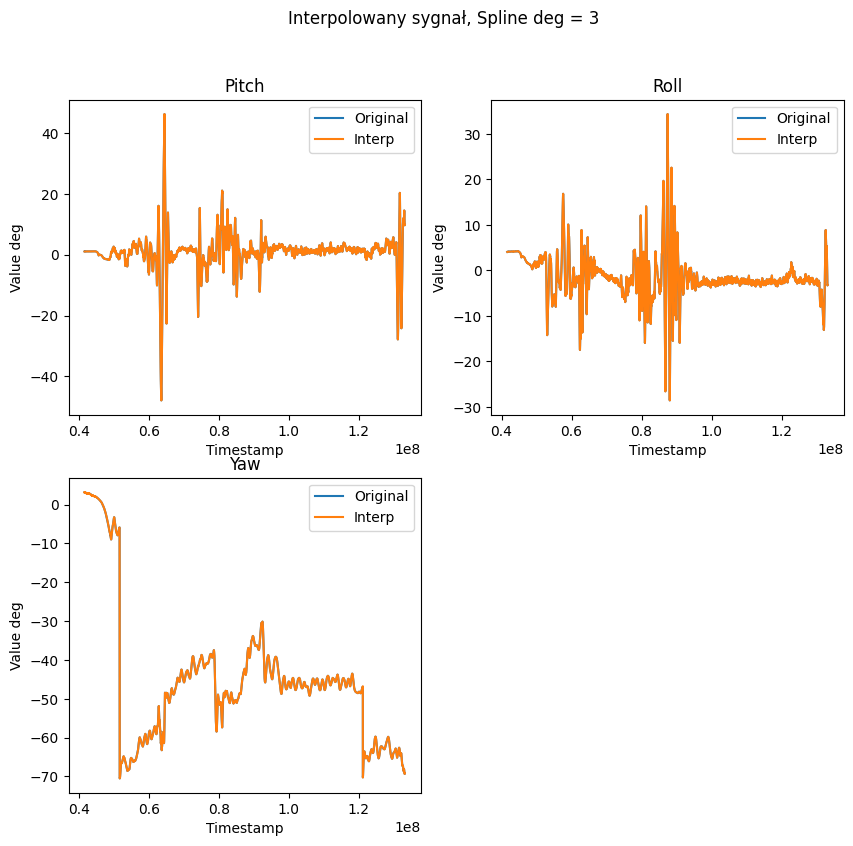

In [4]:
from library.quaternion_vision import display_quaternion_as_euler

display_quaternion_as_euler([att_q, est_q], [att_t, est_t], ['Original', 'Interp'],
    "Interpolowany sygnał, Spline deg = {}".format(degree))

## Implementacja modelu AR
---

### Macierz autokorelacji

In [262]:
r0 = np.quaternion(0.5,0.7,0.2,0.5).normalized()
r1 = np.quaternion(0.5,0.1,0.3,0.2).normalized()
r2 = np.quaternion(0.6,0.3,0.6,0.1).normalized()
r3 = np.quaternion(0.8,0.6,0.5,0.2).normalized()

arr = np.array([[r0,r1,r2,r3],[r1,r0,r1,r2],[r2,r1,r0,r1],[r3,r2,r1,r0]])

a1_1 = r1 / r0

a2_2 = (r2 - a1_1*r1) / (r0 - a1_1*r1)
a1_2 = a1_1 - a2_2 * a1_1

a3_3 = (r3 - a1_2*r1 + a2_2*r2) / (r0 - r1*a2_2 + r2*a1_2)
a1_3 = a1_2 - a3_3 * a2_2
a2_3 = a2_2 - a3_3 * a1_2

# A1 * R0

print("R1")
print(r1)
print((a1_1*r0).normalized())
print((a1_2*r0 + a2_2*r1).normalized())
print((a1_3*r0 + a2_3*r1 + a3_3*r2).normalized())

print("R2")
print(r2)
print((a1_2*r1 + a2_2*r0).normalized())
print((a1_3*r1 + a2_3*r0 + a3_3*r1).normalized())

print("R3")
print(r3)
print((a1_3*r2 + a2_3*r1 + a3_3*r0).normalized())


R1
quaternion(0.800640769025436, 0.160128153805087, 0.480384461415261, 0.320256307610174)
quaternion(0.800640769025436, 0.160128153805087, 0.480384461415261, 0.320256307610174)
quaternion(0.800640769025436, 0.160128153805087, 0.480384461415261, 0.320256307610174)
quaternion(0.800640769025436, 0.160128153805087, 0.480384461415261, 0.320256307610174)
R2
quaternion(0.662589156449079, 0.33129457822454, 0.662589156449079, 0.110431526074847)
quaternion(0.662589156449079, 0.33129457822454, 0.662589156449079, 0.110431526074847)
quaternion(0.662589156449079, 0.33129457822454, 0.662589156449079, 0.110431526074846)
R3
quaternion(0.704360725060499, 0.528270543795374, 0.440225453162812, 0.176090181265125)
quaternion(0.0224905738233758, 0.938637839596463, 0.212421586214162, 0.270795586886195)


In [51]:
def compute_correlation_matrix(windowing_signal: np.ndarray, M_order: int) -> np.ndarray :
    """
    Determines the quaternion correlation matrix.
    Args:
        windowing_signal (np.ndarray[np.quaternion]): Windowing signal
        M_order (int): Filter order

    Returns:
        np.ndarray[np.quaternion]: Corelation matrix 
    """
    n = windowing_signal.size
    r_size = M_order + 1

    r_matrix = np.zeros((r_size, r_size), dtype = np.quaternion)
    for i in range(0, (n - M_order - 1) ):
        v = windowing_signal[i : (i + M_order + 1)]
        r_matrix += np.outer(v, v.conjugate())
    
    return r_matrix

### Levinson-Durbin 

In [ ]:
def compute_coefficient_LD_a(r_matrix: np.ndarray, M_order: int) -> np.ndarray:
    
    a_arr = np.zeros((0), dtype = np.quaternion)
    
    # Step 1: P=0 -> a0 = 1
    # Step 2: P=1
    a_arr = np.append(a_arr, r_matrix[1,0] / r_matrix[1,1])

    # Step 3: Iterative for P in (1 : M_order)
    for i in range(1, M_order):
        nominator   = r_matrix[i+1, 0] - np.sum(a_arr * r_matrix[i, :i])
        denominator = r_matrix[i+1, i+1] - np.sum(a_arr[::-1] * r_matrix[i, :i])
        temp_a = nominator / denominator
        a_arr = np.append(a_arr, temp_a)

        # Coeff actualization 
        for j in range(i):
            a_arr[j] = a_arr[j] - temp_a * a_arr[i-j-1]
    
    return a_arr

In [113]:
def compute_coefficient_LD(r_matrix: np.ndarray, M_order: int) -> np.ndarray:
    
    a_arr = np.zeros((0), dtype = np.quaternion)
    
    # Step 1: P=0 -> a0 = 1
    # Step 2: P=1
    a_arr = np.append(a_arr, r_matrix[1,0] / r_matrix[1,1])

    # Step 3: Iterative for P in (1 : M_order)
    for i in range(1, M_order):
        nominator   = r_matrix[i+1, 0] - np.sum(a_arr * r_matrix[i, :i])
        denominator = r_matrix[i+1, i+1] - np.sum(a_arr[::-1] * r_matrix[i, :i])
        temp_a = nominator / denominator
        a_arr = np.append(a_arr, temp_a)

        # Coeff actualization 
        for j in range(i):
            a_arr[j] = a_arr[j] - temp_a * a_arr[i-j-1]
    
    return a_arr

## Test predykcji
---

In [114]:
# Test v2
N_window = 20
M_order = 2

pred_window = {
    'min': 3000 + N_window,
    'max': 10000,
}
ex_q   = est_q[pred_window['min']:pred_window['max']]
pred_q = np.zeros((pred_window['max'] - pred_window['min']), dtype = np.quaternion)
ex_t = pred_t = est_t[pred_window['min']:pred_window['max']]

for i in range(pred_window['min'], pred_window['max']):
    r_matrix = compute_correlation_matrix(est_q[i-N_window : i], M_order)
    a_arr = compute_coefficient_LD(r_matrix, M_order)
    pred_q[i - pred_window['min']] = np.sum(a_arr * est_q[i-M_order : i]).normalized()


from library.quaternion_utils import quaternion_euler_mse

EULER_COMPONENTS = ['Pitch', 'Roll', 'Yaw']
mse_e = quaternion_euler_mse(ex_q, pred_q)
for mse, c in zip(mse_e, EULER_COMPONENTS):
    print(f'{c+" mse:": <10} {mse}')

Pitch mse: 0.04517769640200042
Roll mse:  0.03105568915847322
Yaw mse:   0.0027491795208765867


In [101]:
# Configuration section
N_window = 20
M_order = 2

pred_window = {
    'min': 3000 + N_window,
    'max': est_t.shape[0],
}
ex_q   = est_q[pred_window['min']:]
pred_q = np.zeros((pred_window['max'] - pred_window['min']), dtype = np.quaternion)
ex_t = pred_t = est_t[pred_window['min']:]

for i in range(pred_window['min'], pred_window['max']):
    r_matrix = compute_correlation_matrix(est_q[i-N_window : i], M_order)
    a_arr = compute_coefficient_LD(r_matrix, M_order)
    pred_q[i - pred_window['min']] = np.sum(a_arr * est_q[i-M_order : i]).normalized()


### Uzyskane rezultaty

#### MSE dla kątów Eulera

In [102]:
from library.quaternion_utils import quaternion_euler_mse

EULER_COMPONENTS = ['Pitch', 'Roll', 'Yaw']
mse_e = quaternion_euler_mse(ex_q, pred_q)
for mse, c in zip(mse_e, EULER_COMPONENTS):
    print(f'{c+" mse:": <10} {mse}')

Pitch mse: 0.02836715146105548
Roll mse:  0.028192105557953144
Yaw mse:   0.04641380624766036


#### Wykres predykcji

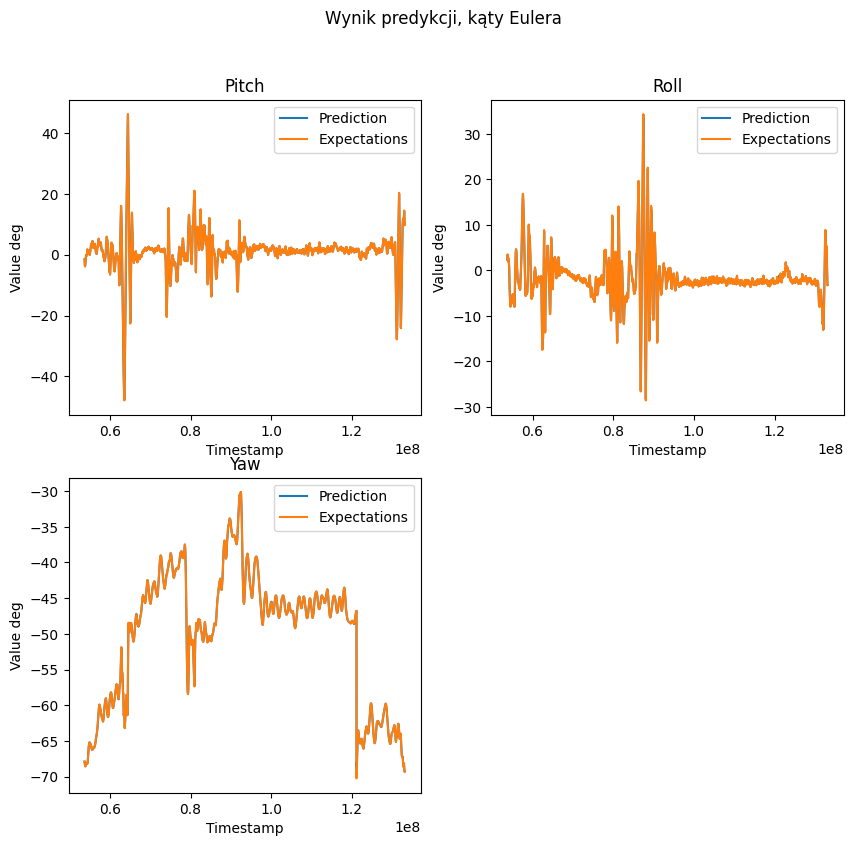

In [61]:
from library.quaternion_vision import display_quaternion_as_euler

display_quaternion_as_euler(
    [pred_q, ex_q], 
    [pred_t, ex_t],  
    ['Prediction', 'Expectations'],
    "Wynik predykcji, kąty Eulera")

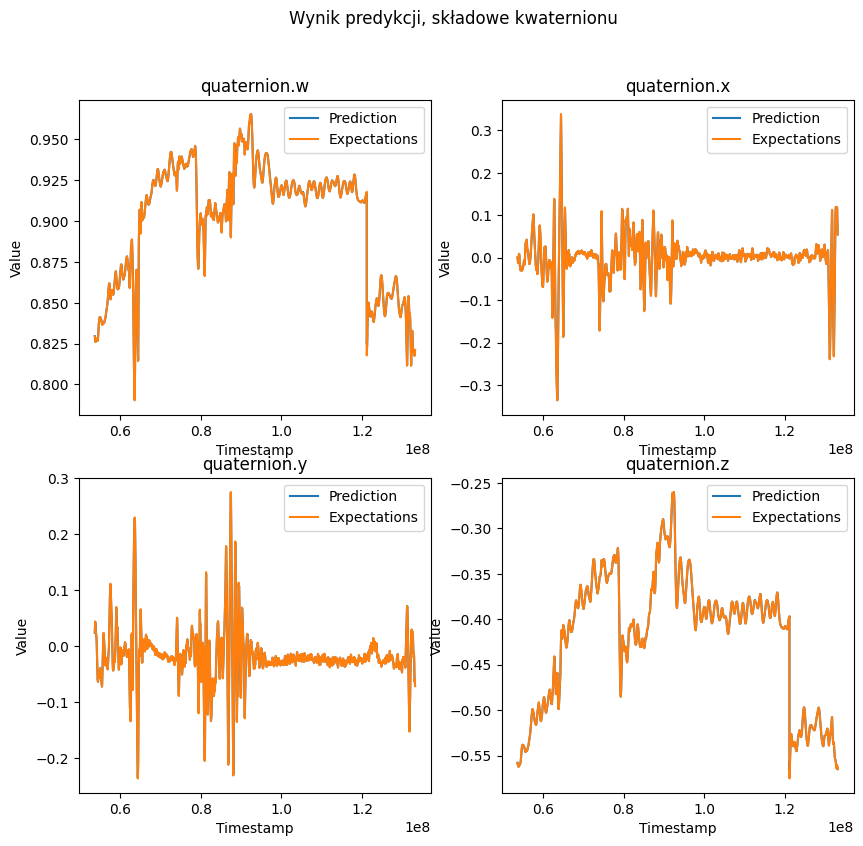

In [47]:
from library.quaternion_vision import display_quaternion_compare

display_quaternion_compare(
    [pred_q, ex_q], 
    [pred_t, ex_t], 
    ['Prediction', 'Expectations'],
    "Wynik predykcji, składowe kwaternionu")